# Time Series Clustering
A comparison between time series distance measures, clustering algorithms and an evaluation on how to select the "optimal" number of clusters.

Divided into three different parts:
- determining a measure to quantify the similarity between observations
- choosing which method to use for obtaining the clustering and
- selecting the desired number of clusters.

Two clustering categories: whole sequence matching and subsequence matching

In [1]:
import pandas as pd
import numpy as np
from tslearn.datasets import UCR_UEA_datasets

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.set_cmap('bone')

%matplotlib inline

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

In [2]:
datasets = UCR_UEA_datasets()

#list datasets
# datasets.list_datasets()

#load dataset
X, labels, _, _ = datasets.load_dataset('InsectWingbeatSound')
X.shape

(220, 256, 1)

In [3]:
def reduce_dimensions(array):
    """
        reshape array from 3d to 2d
        
        array - array to be reduced
    """
    return array.transpose(2,0,1).reshape(-1, array.shape[1])

def tsdata_to_dataframe(dataset):
    """
        Convert a tslearn dataset in to a pandas dataframe each column a time series
        
        dataset - tslearn dataset
    """
    #Reshape data from 3d to 2d
    dataset = reduce_dimensions(dataset)
    return pd.DataFrame(dataset)

data = tsdata_to_dataframe(X)
test_data = data.copy()

In [4]:
def plot_ts_clusters(timeseries, result):
    """
        Plot clustering results
        
        timeseries - timeseries data
        result - cluster labels
    """
    clusters = list(set(result))
    
    if not isinstance(result, pd.Series):
        result = pd.Series(result)
        
    fig, axis = plt.subplots(3, int(len(clusters)/2), figsize=(20,10))
    fig.suptitle(f'Clusters - {result.name}', fontsize=16)
    
    for i, ax in enumerate(axis.ravel()):
        if i < len(clusters):
            cluster_index = result[result==clusters[i]].index
            ax.plot(timeseries.T.iloc[:,cluster_index], c=np.random.rand(3,))
            ax.set_title(f'Cluster: {clusters[i]} has {len(cluster_index)} elements', fontsize=15, fontweight='bold')
        else:
            fig.delaxes(ax)

In [5]:
labels = pd.Series(labels, name='labels')
n_clusters = len(list(set(labels)))
test_data['labels'] = labels

Text(0, 0.5, 'Values')

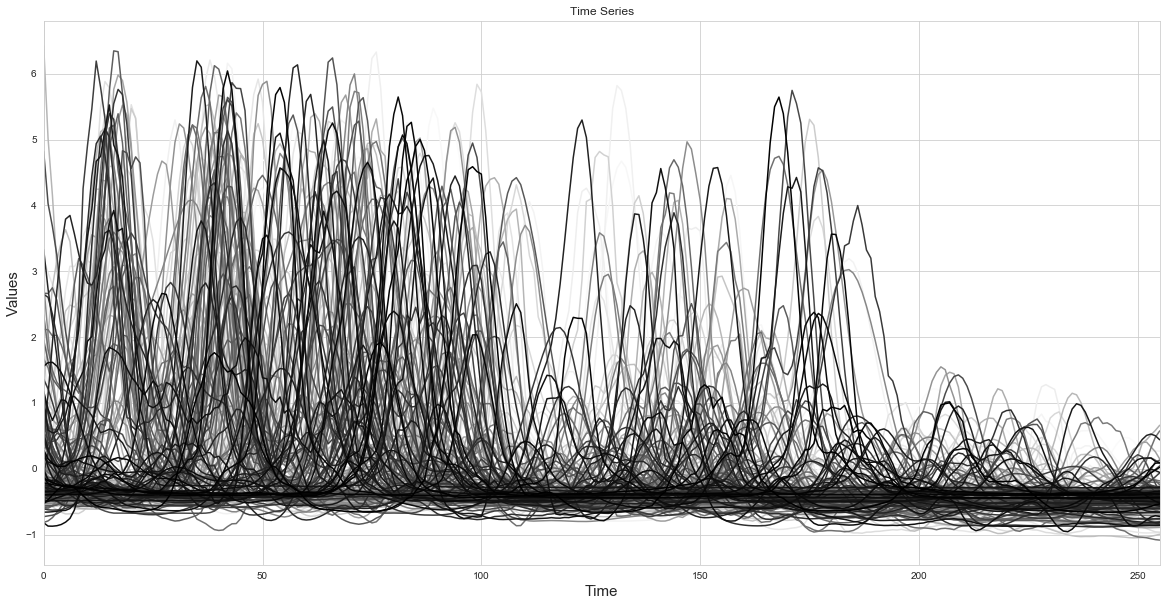

In [6]:
ax = data.T.plot(figsize=(20,10), legend=False, title='Time Series', cmap='Greys')
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("Values", fontsize=15)

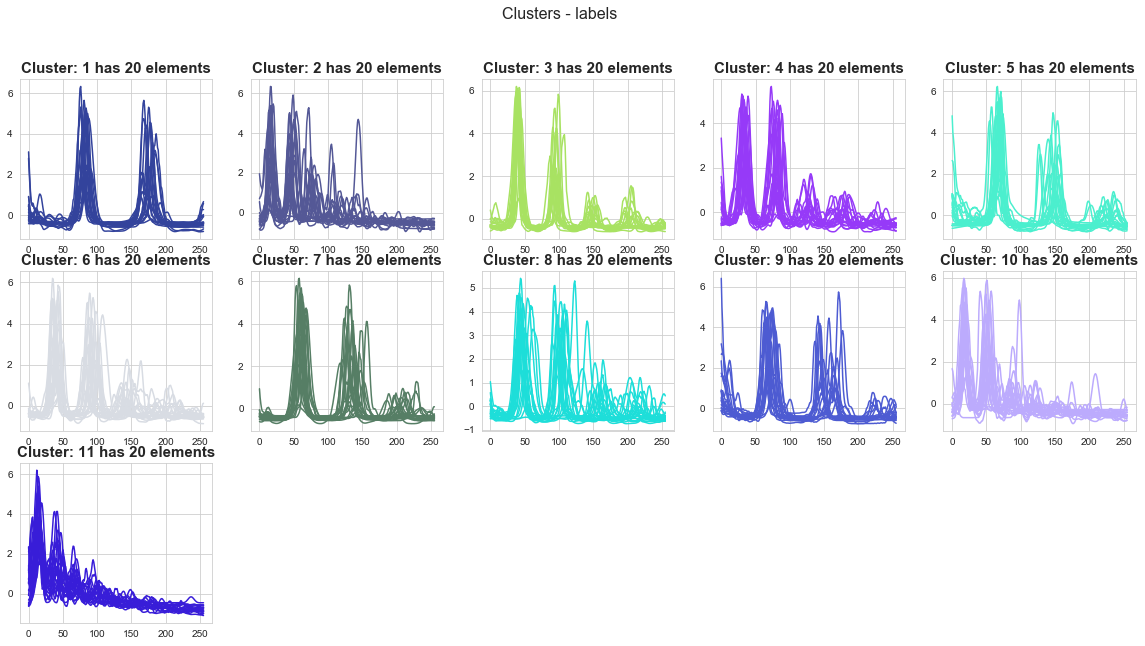

In [7]:
plot_ts_clusters(data, labels)

## Distance Measures
Distance measures can be divided into three different categories: lock-step, elastic and feature-based distance measures.

<table align="center">
  <tr>
    <th><b>lock-step</b></th>
    <th><b>elastic</b></th>
    <th><b>feature-based</b></th>
  </tr>
  <tr>
    <td>Minkowski (∀p)</td>
    <td>Dynamic Time Warping (DTW)</td>
    <td>Discrete Fourier Transform (DFT)</td>
  </tr>
  <tr>
    <td>Pearson correlation</td>
    <td>LB Keogh</td>
    <td>Discrete Wavelet Transform (DWT)</td>
  </tr>
  <tr>
    <td>Euclidean distance</td>
    <td> </td>
    <td>Symbolic Aggregate approXimation (SAX)</td>
  </tr>
</table>

Generally, it can be stated that choosing a good distance measure is a trade-off between speed and accuracy.</br>

Elastic measures tend to outperform lock-step measures, but for large data sets this difference in performance becomes less significant.</br>

Feature-based measures are often used for large data sets, as they provide dimensionality reduction and thereby reduce the calculation time.

### Lock-Step Methods
Lock-step measures require both time series to be of equal length (n = m) and compare time point i of time series x with time point i of time series y.

Lock-step distance measures are sensitive to noise, scale and time shifts.

determining the distance matrix with this measure takes O(nN^2) time where N is the number of time series

### Elastic Measures
Elastic measures are flexible and allow one-to-many or one-to-none point matchings i.e. time series don't have to be of equal length. This comes with an increase in time complexity

### Feature Based

Feature-based distances, first extracts features from the time series and then measures the distance between these features.
Feature-based distances are often applied to obtain a reduction in both dimensionality and noise.

They are used when dealing with large (noisy) data sets

In [8]:
def lb_keogh(X1, X2, radius=0.5):
    """
        lb keogh distance measure
        
        X1 - timeseries
        X2 - timeseries
    """
    from tslearn.metrics import lb_envelope, lb_keogh
    
    
    env_low, env_up = lb_envelope(X1, radius=radius)
    return lb_keogh(ts_query=X2, envelope_candidate=(env_low, env_up)) 

In [9]:
from sklearn.metrics import pairwise_distances
from tslearn.metrics import dtw, soft_dtw, cdist_dtw, cdist_soft_dtw

# lock-step-method distance matrix - pass the metric name
distance_matrix_minkowski = pairwise_distances(data, metric = 'minkowski')
distance_matrix_corr = pairwise_distances(data, metric = 'correlation')
distance_matrix_euclidean = pairwise_distances(data, metric = 'euclidean')
distance_matrix_dtw = cdist_dtw(X, n_jobs=-1) #DTW
distance_matrix_soft_dtw = cdist_soft_dtw(X) #Soft-DTW
distance_matrix_lb_keogh = pairwise_distances(data, metric = lb_keogh) #lb Keogh

## Clustering Methods

#### Partitioning Methods
Agglomerative clustering
#### Hierachical Methods
k-means

K-medoids

KShape

### Agglomerative Clustering

Cophenetic Correlation Coefficient compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

distances = [distance_matrix_lb_keogh, distance_matrix_soft_dtw, distance_matrix_dtw,\
             distance_matrix_euclidean, distance_matrix_corr, distance_matrix_minkowski]
metric_names = ['lb keogh', 'DTW-Soft', 'DTW', 'Euclidean', 'Correlation', 'Minkowski']
metrics = [lb_keogh, soft_dtw, dtw, 'euclidean', 'correlation', 'minkowski']

for i, distance in enumerate(distances):
    Z = linkage(distance, method='average')
    c, _ = cophenet(Z, pdist(data, metric=metrics[i]))
    print(f'{metric_names[i]}: {c}')

lb keogh: 0.7715465706537677
DTW-Soft: 0.6862459135298012
DTW: 0.730636183333123
Euclidean: 0.7690618520491409
Correlation: 0.7426844795216868
Minkowski: 0.7690618520685868


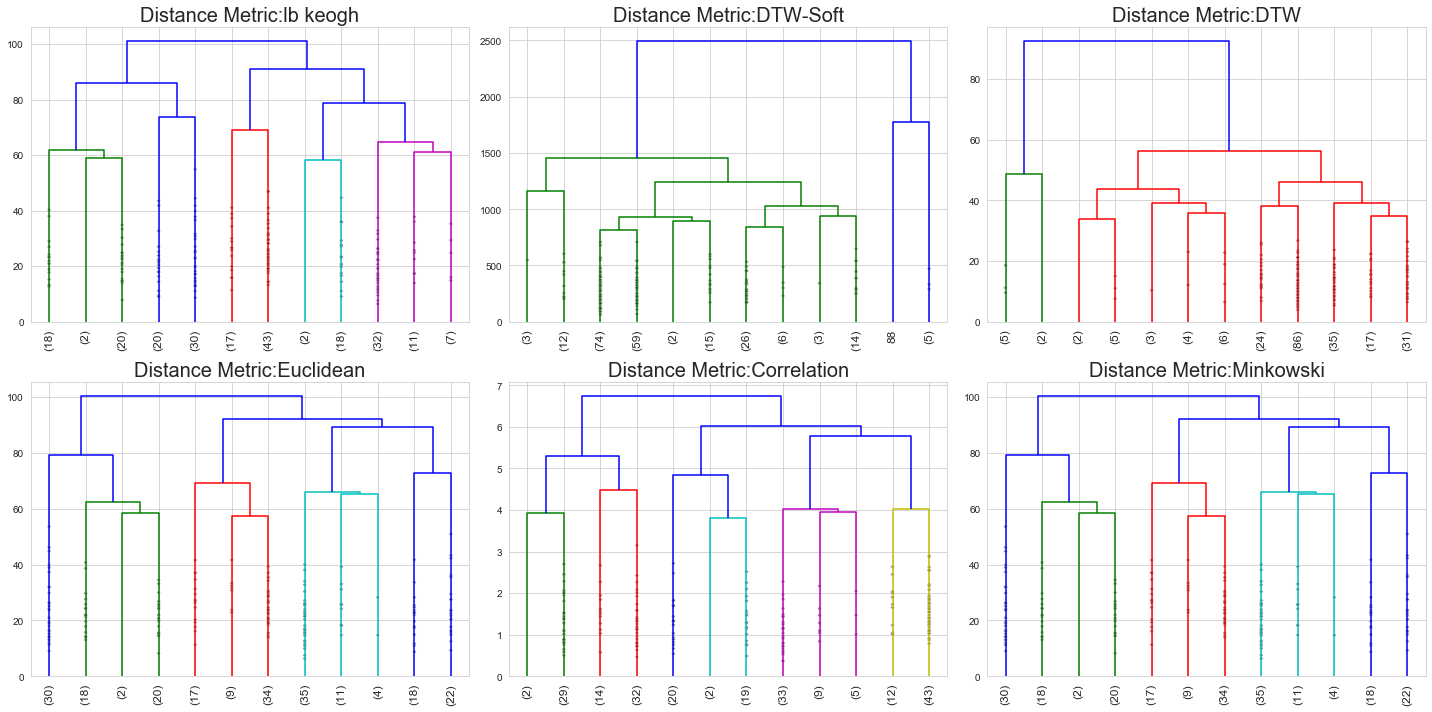

In [11]:
fig, axis = plt.subplots(2, int(len(distances)/2), figsize=(20,10))

for i, ax in enumerate(axis.ravel()):
    Z = linkage(distances[i], method='average')
    dendrogram(Z,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=12,  # show only the last p merged clusters
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            ax=ax)
    ax.set_title(f'Distance Metric:{metric_names[i]}', fontsize=20)

plt.tight_layout()

#### Retrieve Clusters

In [12]:
from scipy.cluster.hierarchy import fcluster

# Knowing K
K=n_clusters

for i, distance in enumerate(distances):
    Z = linkage(distance, method='average')

    clusters = fcluster(Z, K, criterion='maxclust')
    test_data[f'{metric_names[i]}'] = clusters

# Based on the cut-off distance
# max_d = 50
# clusters = fcluster(Z, max_d, criterion='distance')
# test_data['lb keogh'] = clusters

### K-Means Clustering

In [13]:
from tslearn.clustering import TimeSeriesKMeans

metrics = ['dtw', 'softdtw', 'euclidean']
for metric in metrics:
    kmeans_labels = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric,\
                           init='k-means++', n_jobs=-1,  random_state=RANDOM_STATE).fit_predict(data)

    test_data[f'kmeans_{metric}'] = kmeans_labels

### KShape Clustering

In [14]:
from tslearn.clustering import KShape

kshape_labels = KShape(n_clusters=n_clusters, random_state=RANDOM_STATE).fit_predict(data)

test_data['kshape'] = kshape_labels

### K-Medoids Clustering

In [15]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# Initialise medoids
initial_medoids = kmeans_plusplus_initializer(data, n_clusters).initialize(return_index=True)

for idx, distance in enumerate(distances):
    kmedoids_instance = kmedoids(distance, initial_medoids, data_type='distance_matrix')
    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    
    label_name = f'kmedoids_{metric_names[idx]}'
    
    for i in range(0, len(clusters)):
            if i == 0:
                labels = pd.DataFrame([i]*len(clusters[i]),index=clusters[i], columns=[label_name])
            else:
                labels = pd.concat([labels, pd.DataFrame([i]*len(clusters[i]),index=clusters[i], columns=[label_name])])
                
    labels = labels.apply(lambda x: x+1)
    
    if label_name in test_data:
        test_data.drop(columns=[label_name], inplace=True)
        
    test_data = pd.merge(test_data, labels, left_index=True, right_index=True)

## Determining the number of clusters
Calinski-Harabasz index (only for euclidean distance measure) - ratio between the within-cluster dispersion and the between-cluster dispersion

Davies Bouldin Index - ratio of within-cluster distances to between-cluster distances.

Silhouette index - based on compactness and separation of clusters.

Inertia/distortion 

It's a good idea to apply more than one method and if most methods agree on a certain number of clusters, there is a good indication of a clear clustering structure in the data.

#### Inertia/Distortion Plots - Elbow Method

Text(0.5, 1.0, 'Distortion')

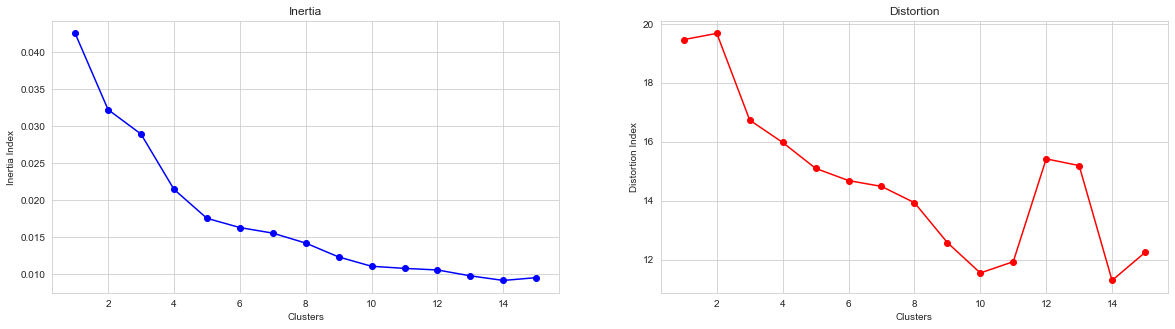

In [16]:
from scipy.spatial.distance import cdist 

X = data
distortions = [] 
inertias = [] 

cluster_range = range(1, n_clusters+5)

for cluster in cluster_range:
    model = KShape(n_clusters=cluster, random_state=RANDOM_STATE).fit(X) #Model fitting
    model.cluster_centers_
    distortions.append(sum(np.min(cdist(X, reduce_dimensions(model.cluster_centers_)),axis=1)) / X.shape[0]) 
    inertias.append(model.inertia_)

# Inertia, distortion elbow plots
fig, axis = plt.subplots(1, 2, figsize=(20,5))

#Inertia Plot
axis[0].plot(cluster_range, inertias, 'bo-')
axis[0].set_xlabel('Clusters') 
axis[0].set_ylabel('Inertia Index') 
axis[0].set_title('Inertia')
# Distortion Plot
axis[1].plot(cluster_range, distortions, 'ro-')
axis[1].set_xlabel('Clusters') 
axis[1].set_ylabel('Distortion Index') 
axis[1].set_title('Distortion')

#### calinski_harabasz_score

The score is higher when clusters are dense and well separated

#### davies_bouldin_score
clusters which are farther apart and less dispersed will result in a lower score.

Text(0.5, 1.0, 'Davies Bouldin')

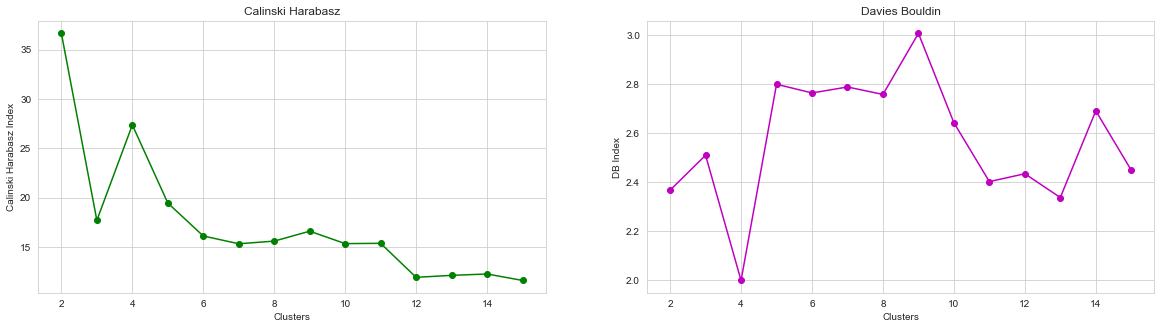

In [17]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

X = data
cluster_range = range(2, n_clusters+5)
calinski_harabasz = []
DB = []

for cluster in cluster_range:
    prediction = KShape(n_clusters=cluster, random_state=RANDOM_STATE).fit_predict(X) #Model
    calinski_harabasz.append(calinski_harabasz_score(X, prediction))
    DB.append(davies_bouldin_score(X, prediction))

              
fig, axis = plt.subplots(1, 2, figsize=(20,5))

#calinski harabasz Plot
axis[0].plot(cluster_range, calinski_harabasz, 'go-')
axis[0].set_xlabel('Clusters') 
axis[0].set_ylabel('Calinski Harabasz Index') 
axis[0].set_title('Calinski Harabasz')
# DB Index Plot
axis[1].plot(cluster_range, DB, 'mo-')
axis[1].set_xlabel('Clusters') 
axis[1].set_ylabel('DB Index') 
axis[1].set_title('Davies Bouldin')

## Compare Clustering Algorithms

#### Silhouette Score

In [18]:
def ts_silhouette_plot(data, clusters: list, metric='euclidean'):
    """
        Plot silhouette
        data - dataset used for clustering
        clusters - list of cluster labels
    """
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.cm as cm
    
    # Create a subplot with 1 row and 2 columns
    fig, axis = plt.subplots(1, 1, figsize=(15,10))
    
    data = np.array(data)
    # The 1st subplot is the silhouette plot
    
    # The silhouette coefficient can range from -1, 1
    axis.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    axis.set_ylim([0, len(data) + (len(set(clusters)) + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, clusters, metric=metric)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, clusters, metric=metric)

    y_lower = 10
    n_clusters = len(set(clusters))
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        axis.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        axis.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    axis.set_title(f"The silhouette plot for the various clusters. - {clusters.name}")
    axis.set_xlabel(f"The silhouette coefficient values - average: {round(silhouette_avg, 3)}")
    axis.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    axis.axvline(x=silhouette_avg, color="red", linestyle="--")

    axis.set_yticks([])  # Clear the yaxis labels / ticks
    axis.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

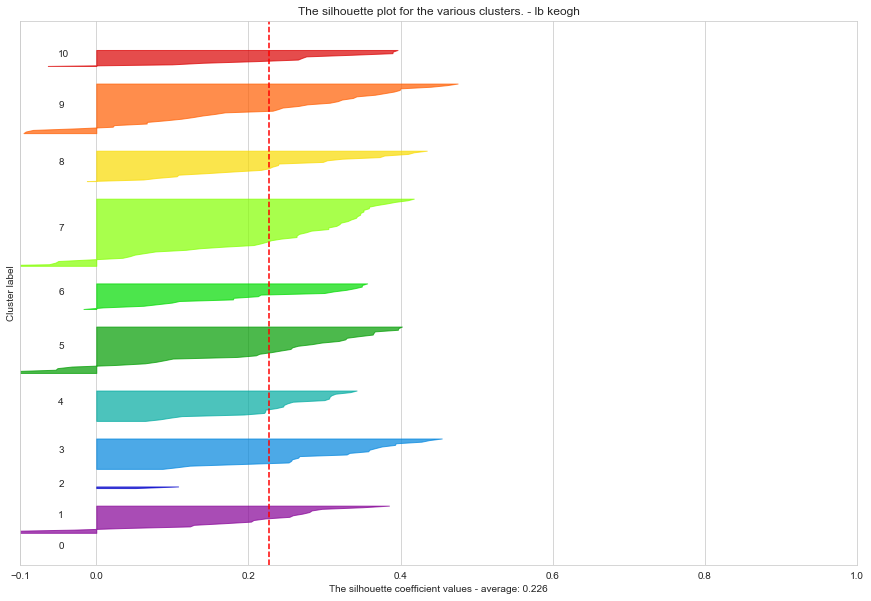

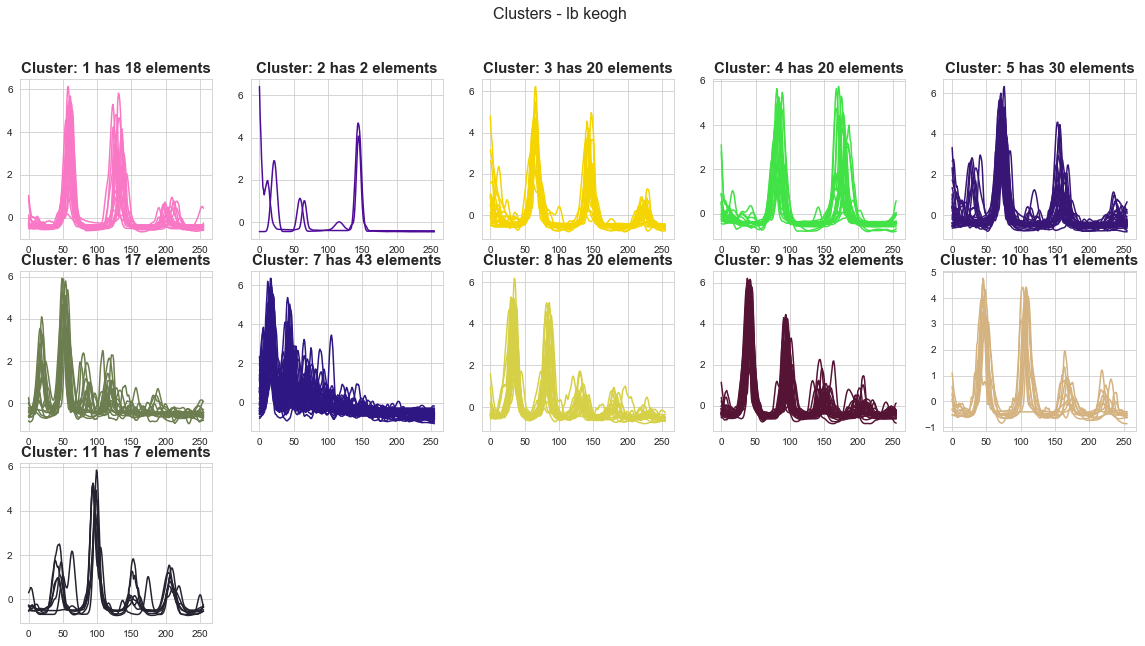

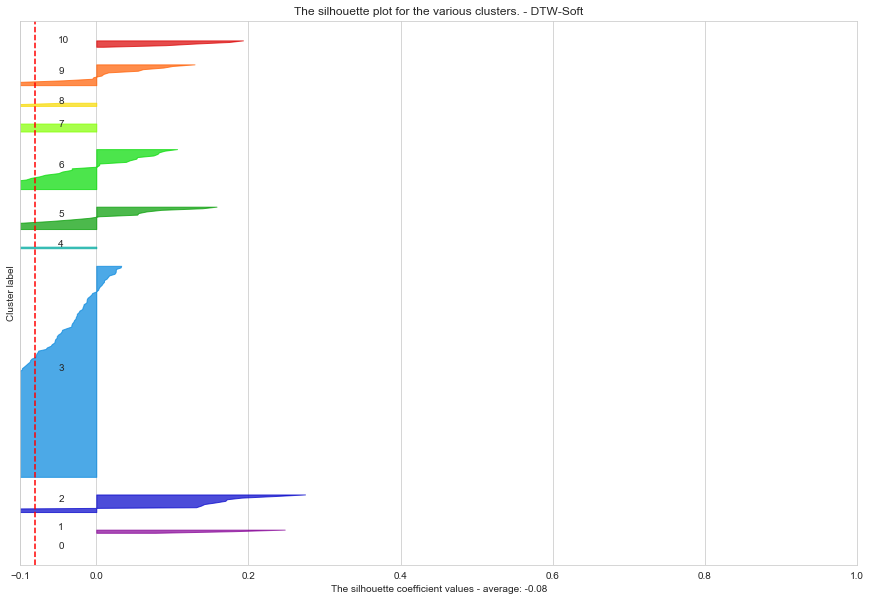

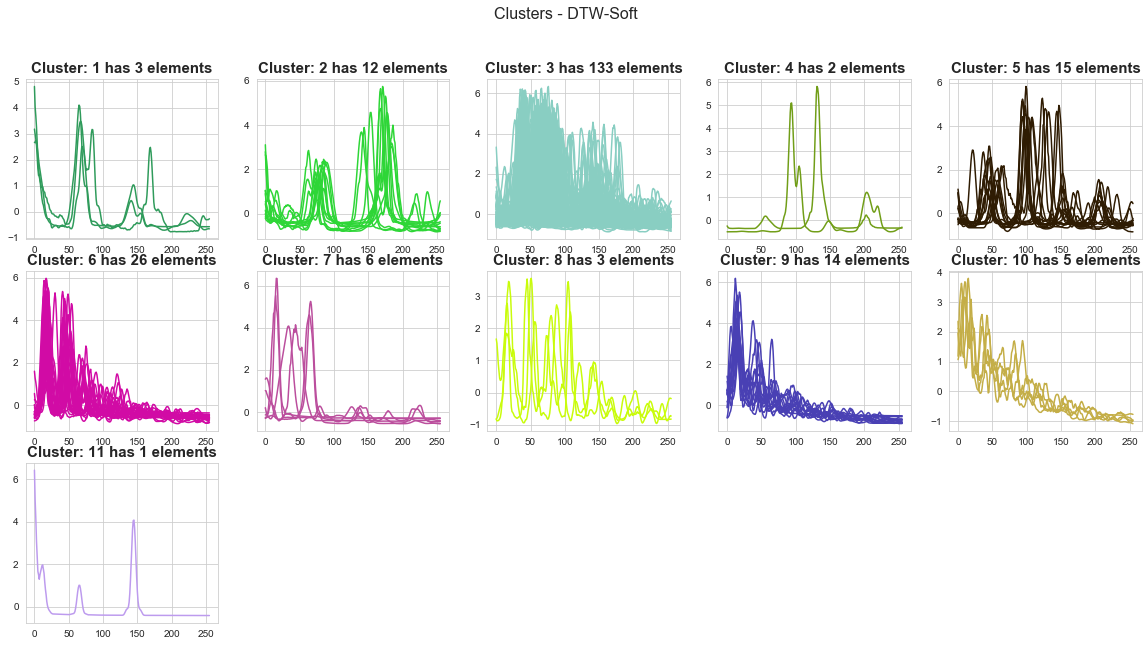

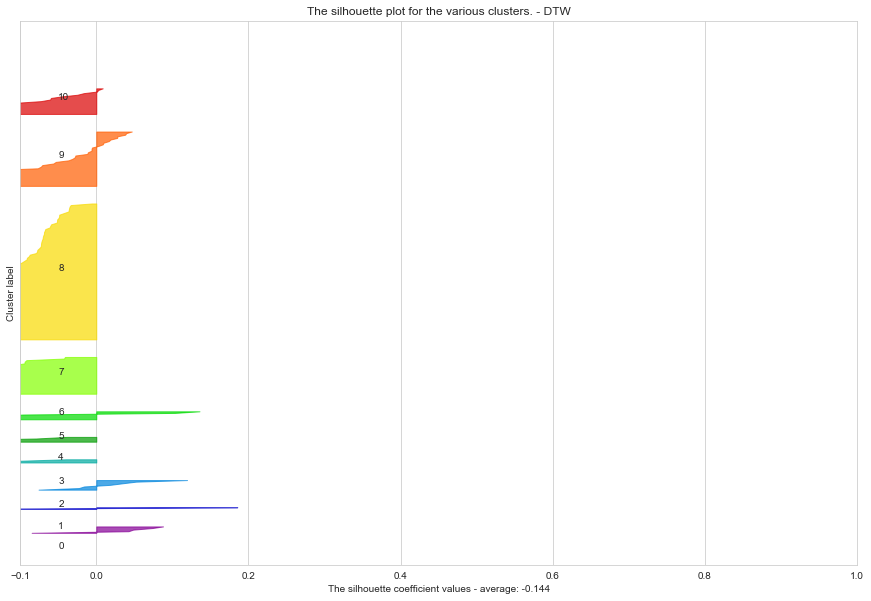

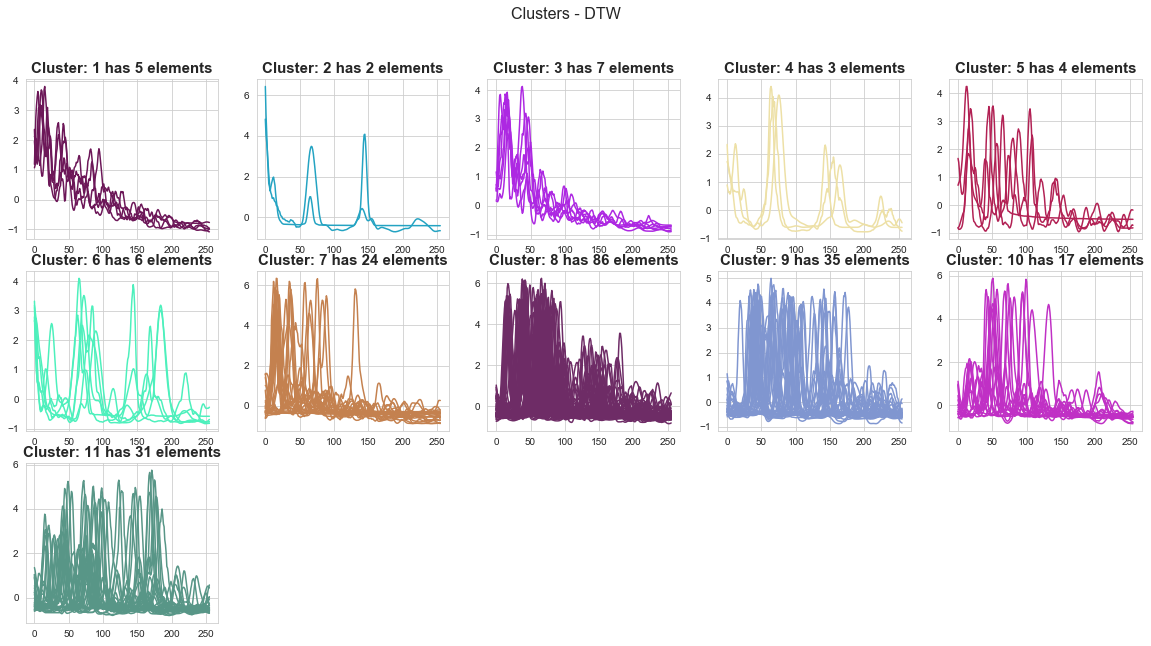

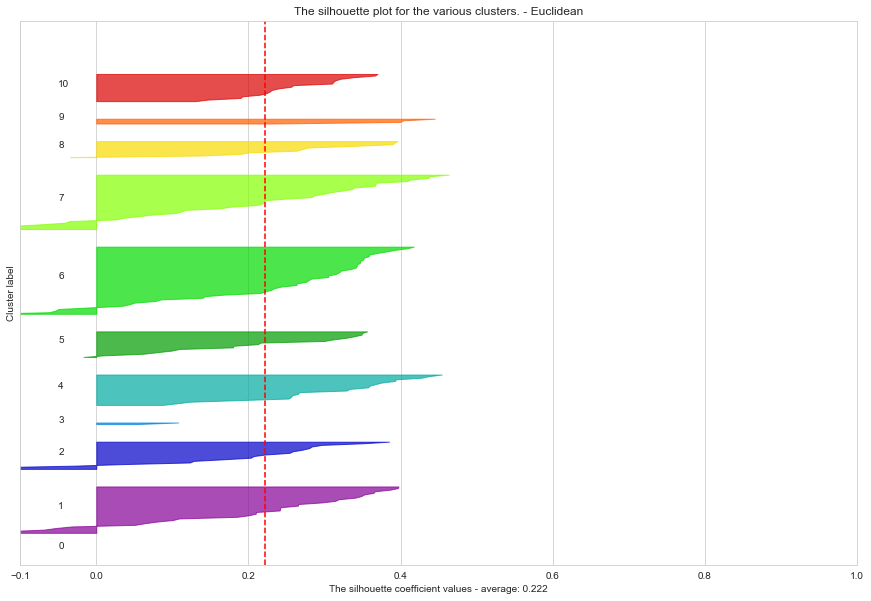

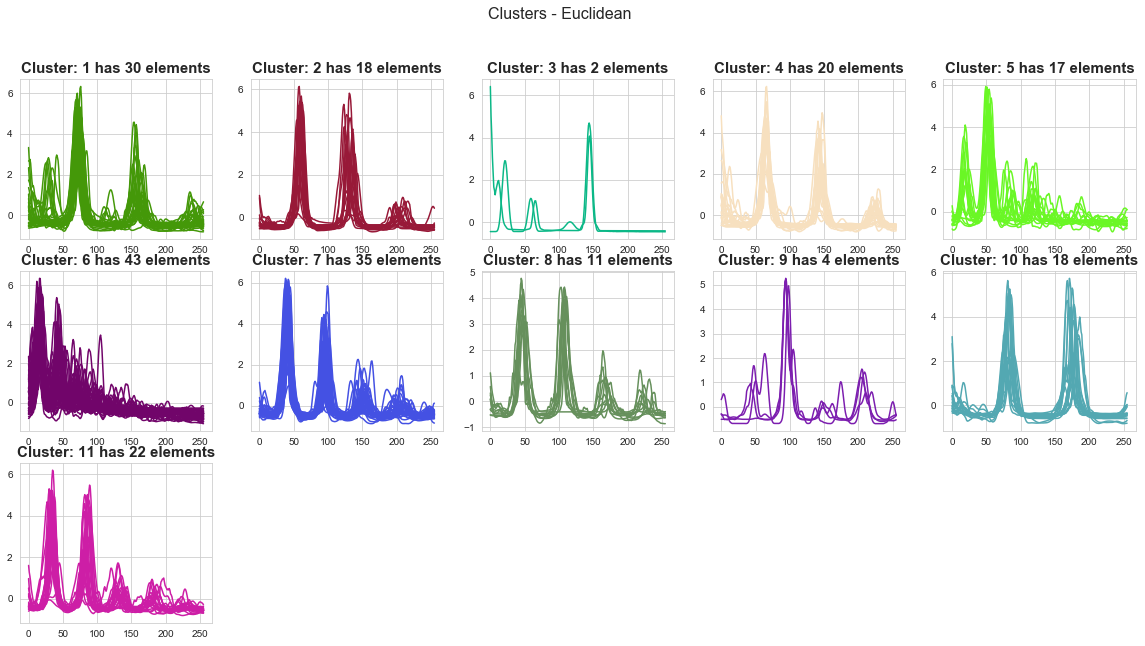

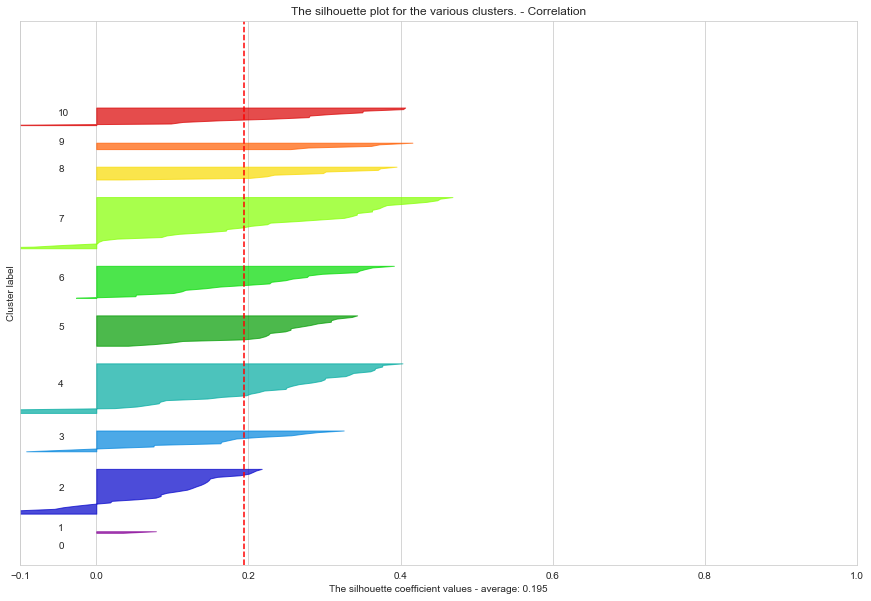

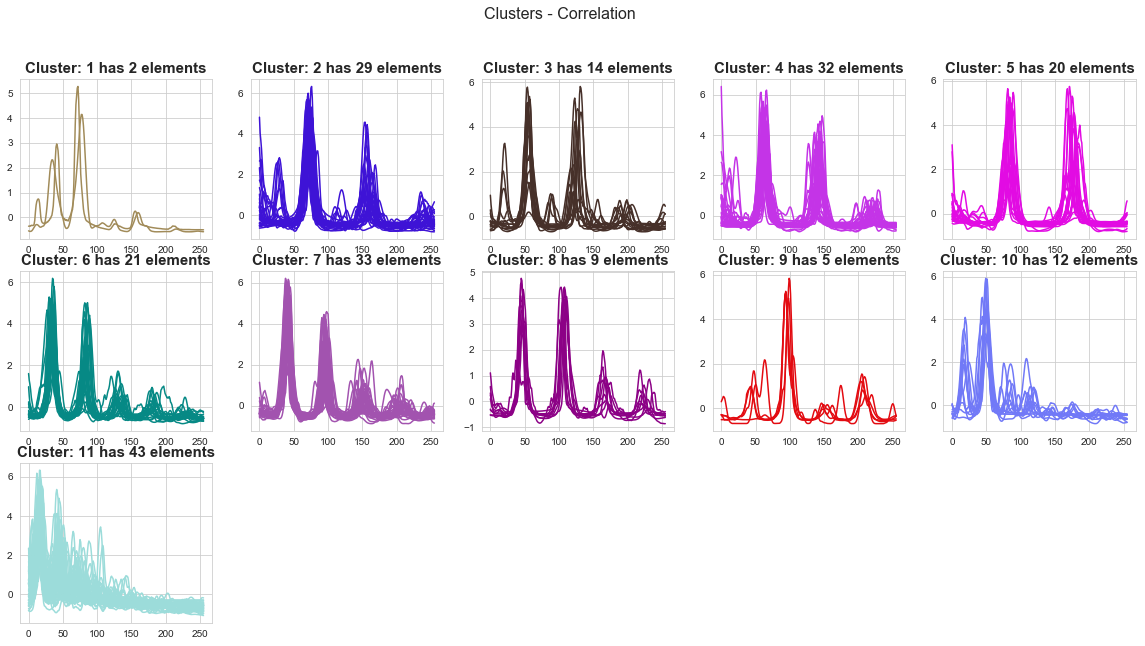

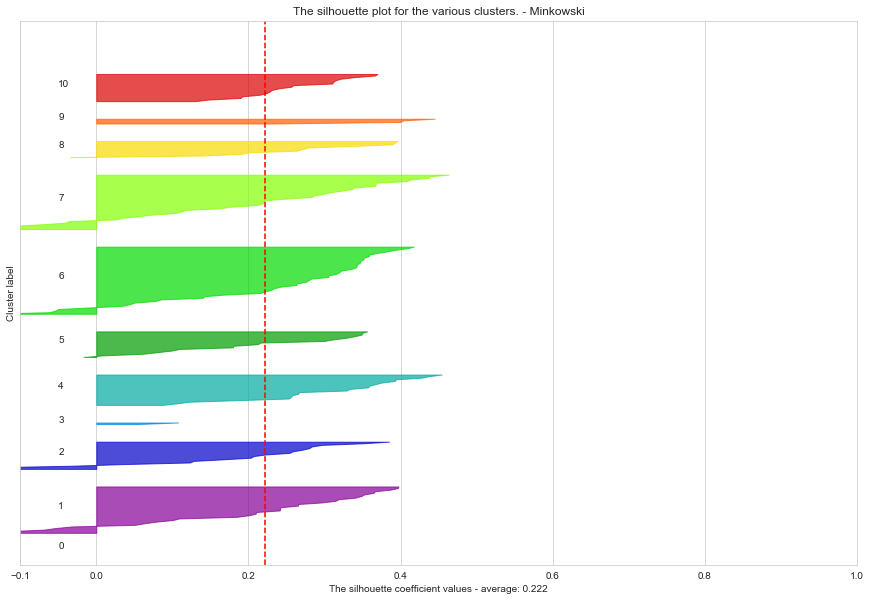

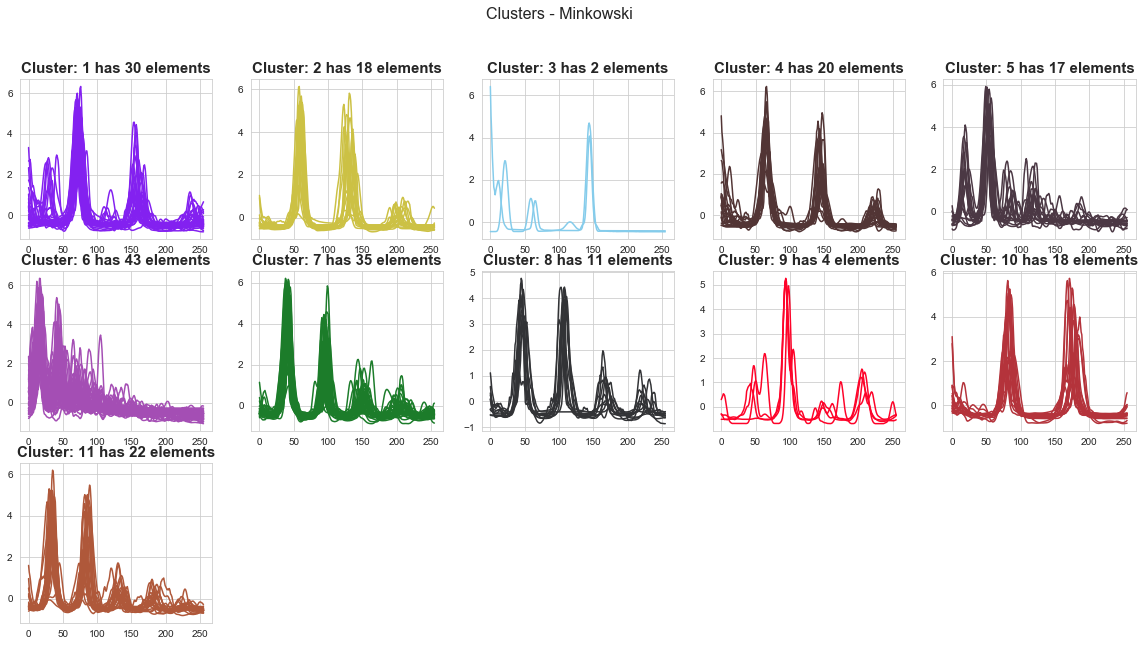

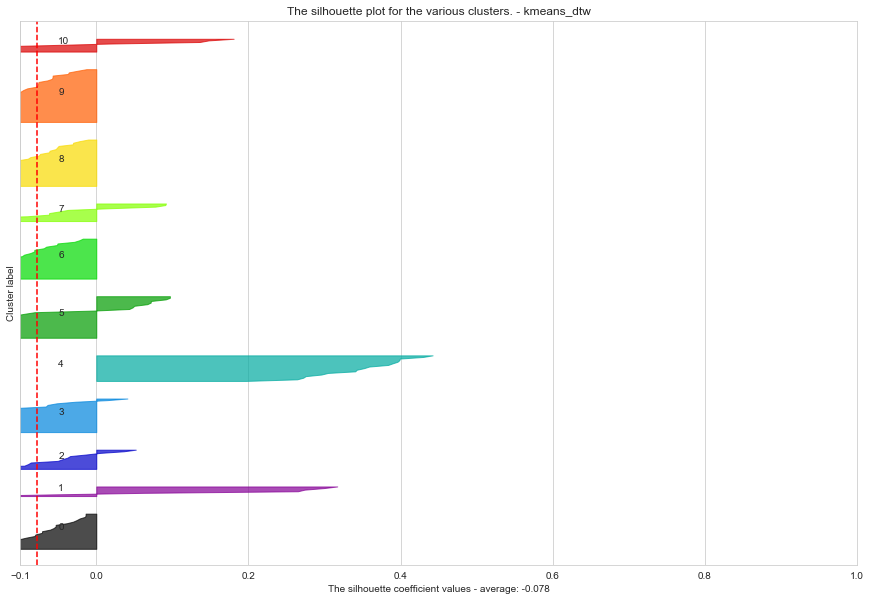

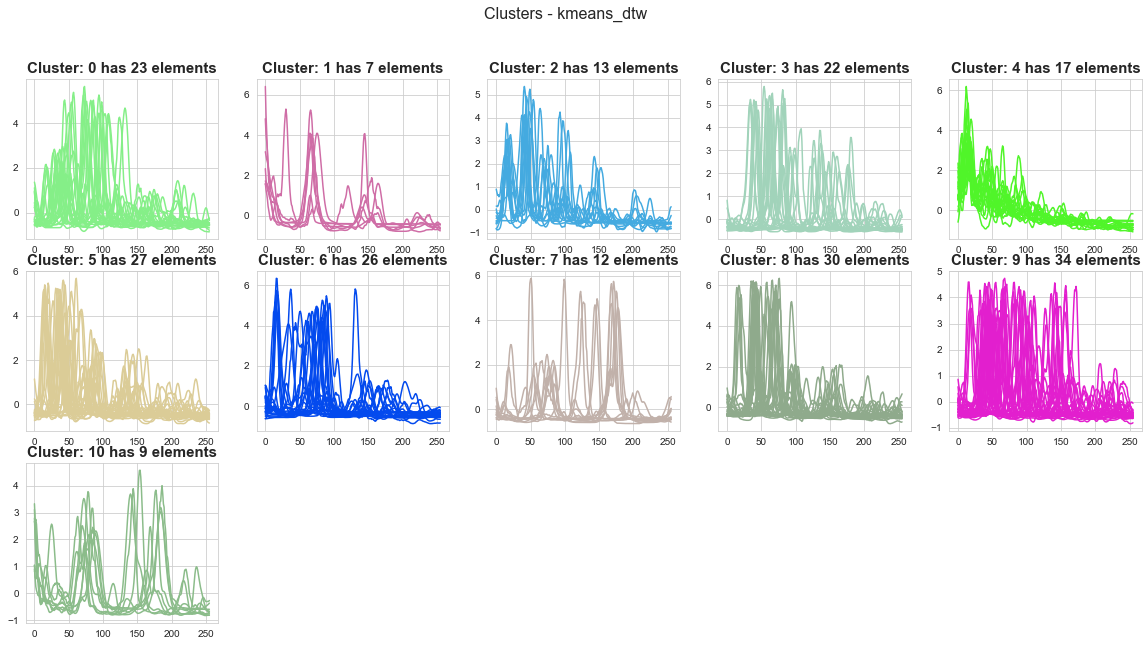

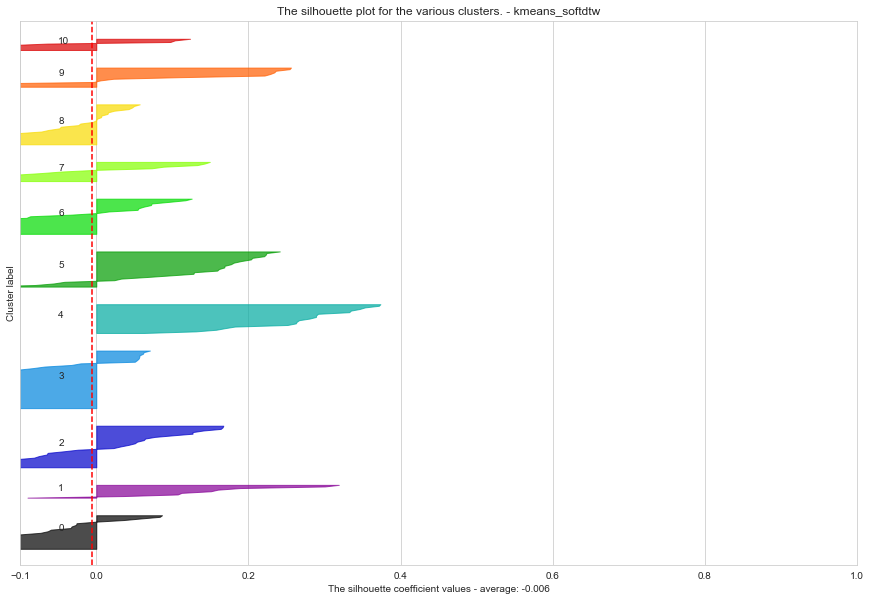

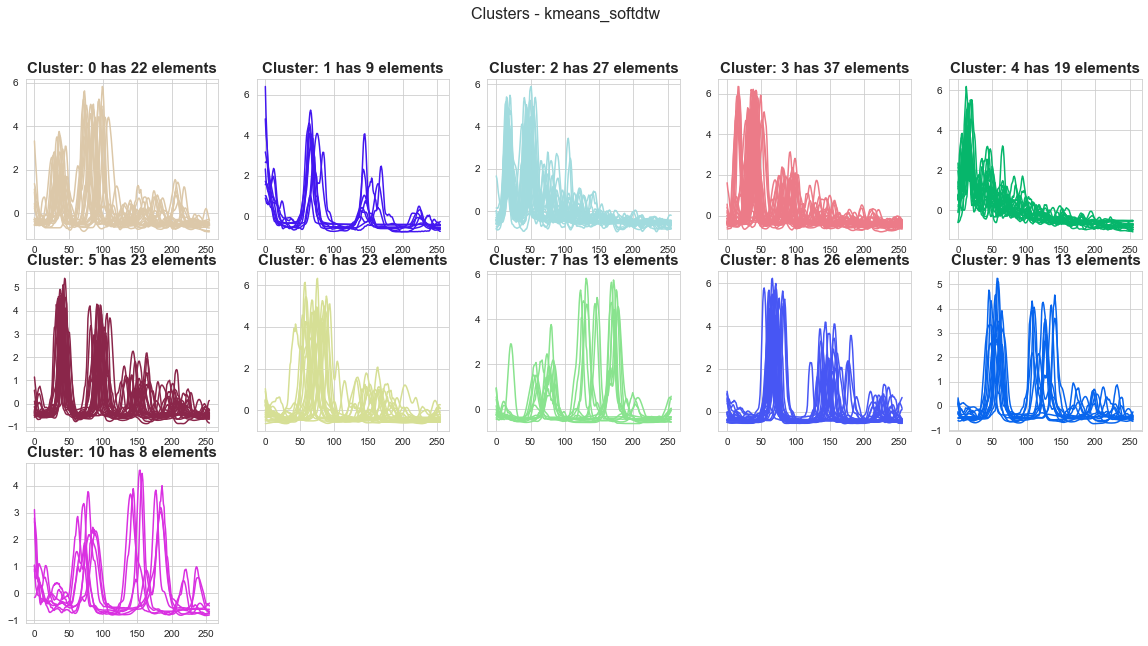

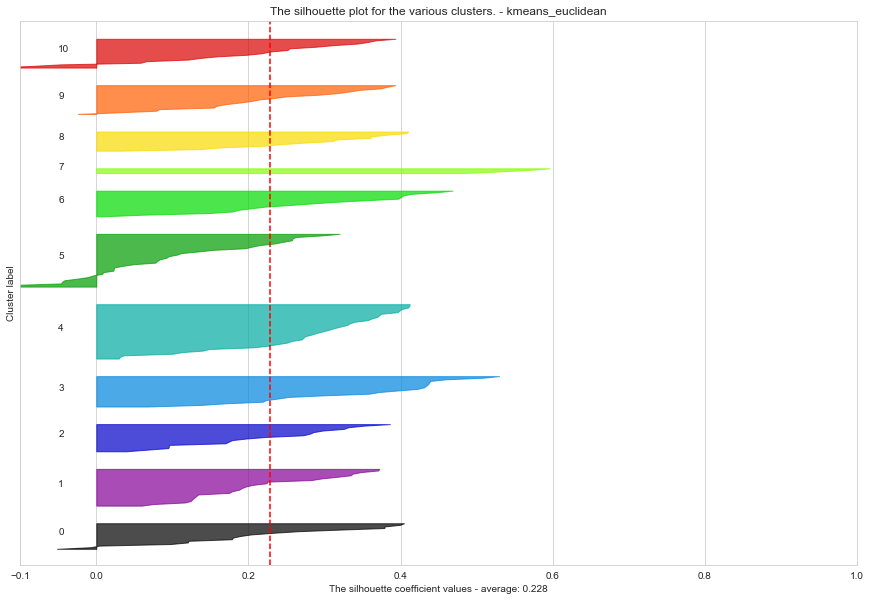

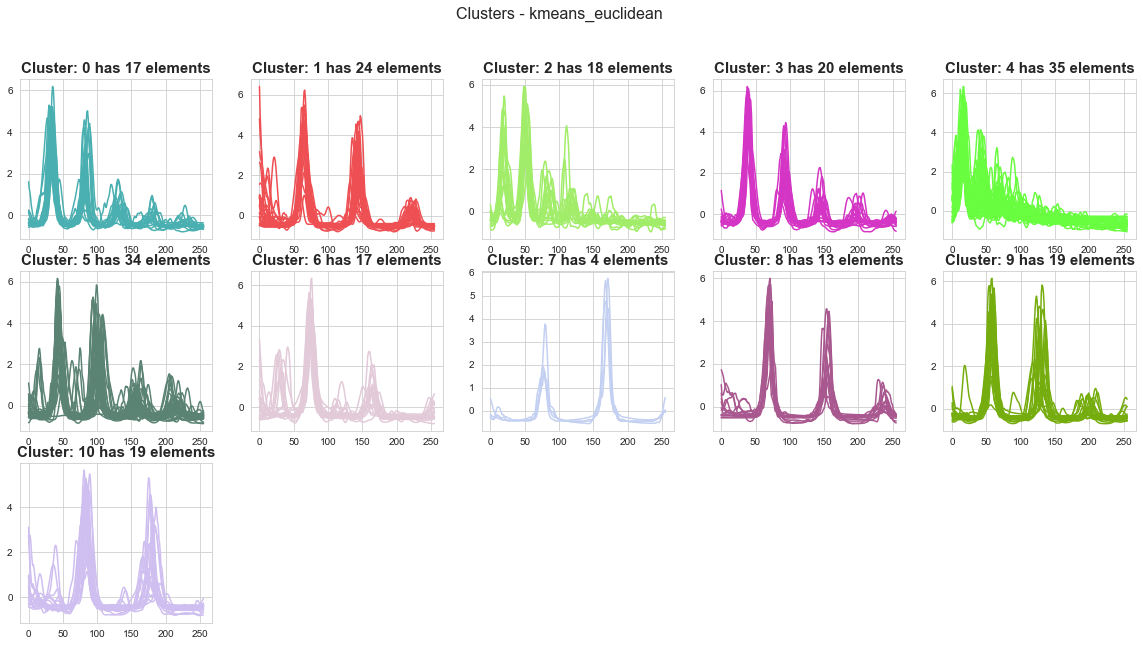

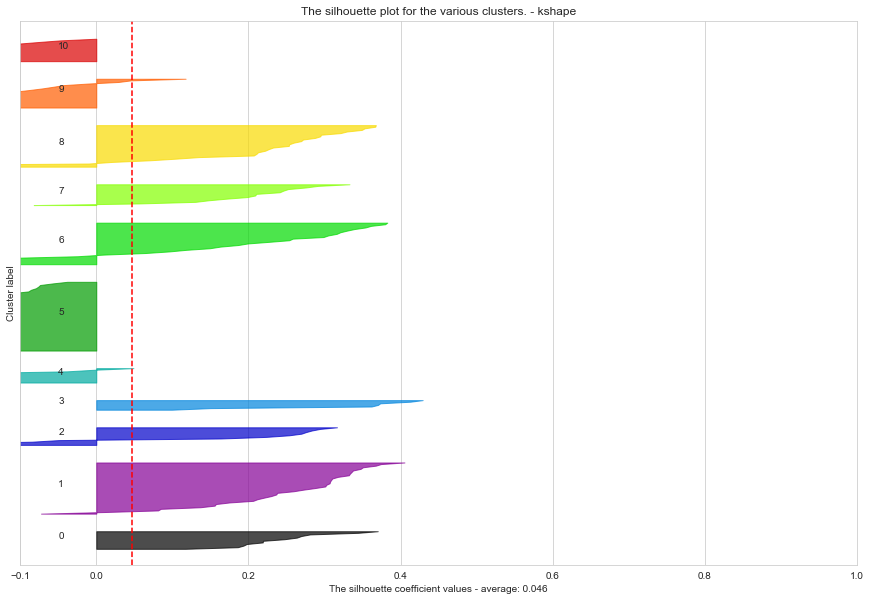

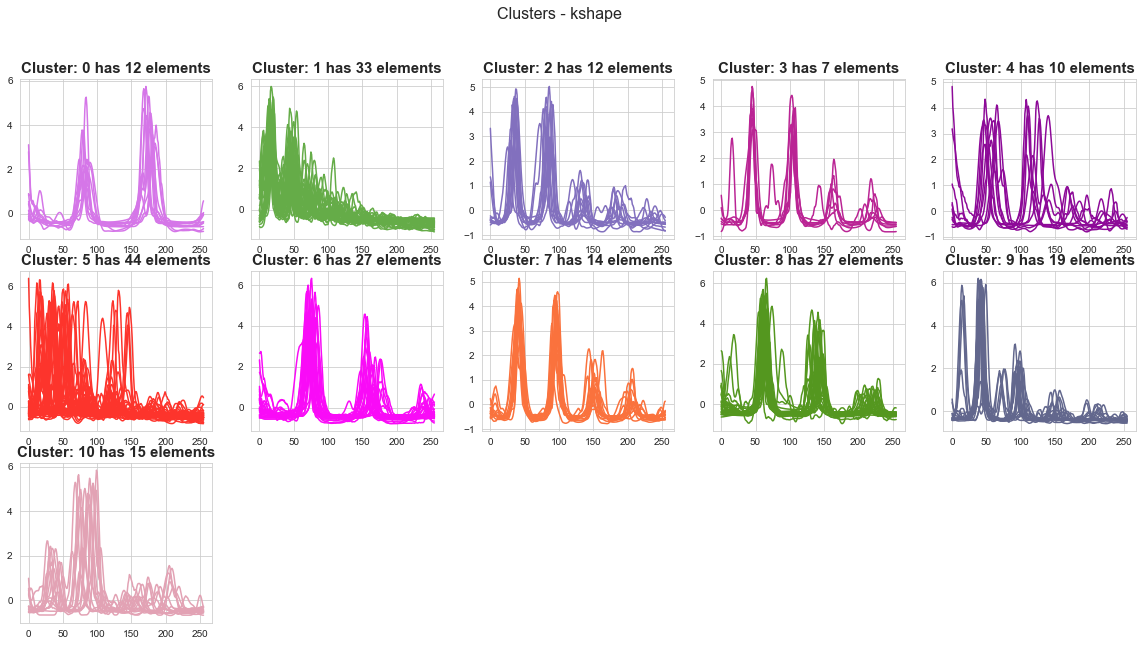

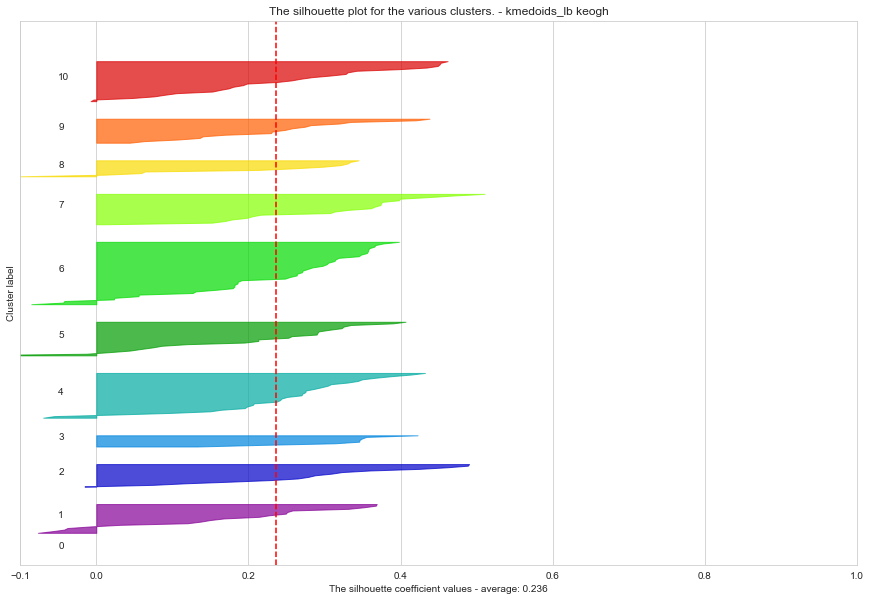

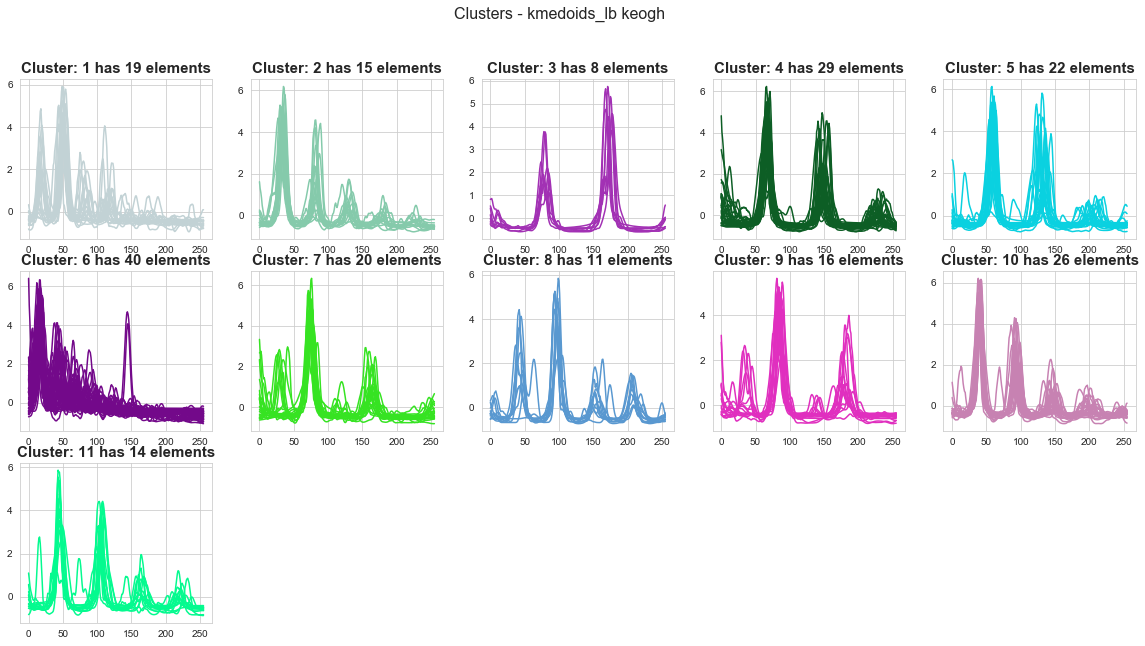

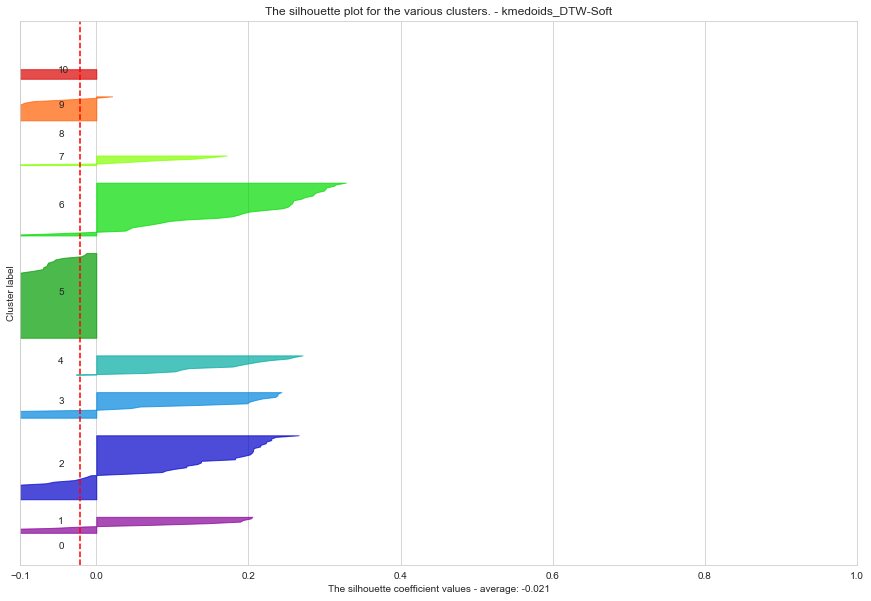

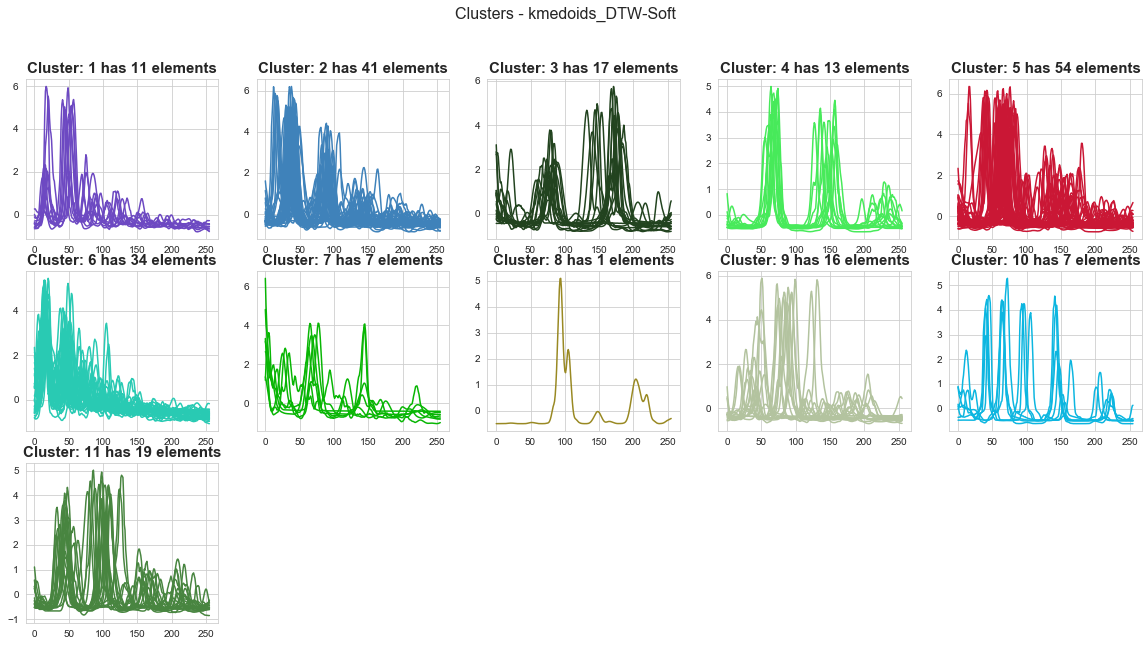

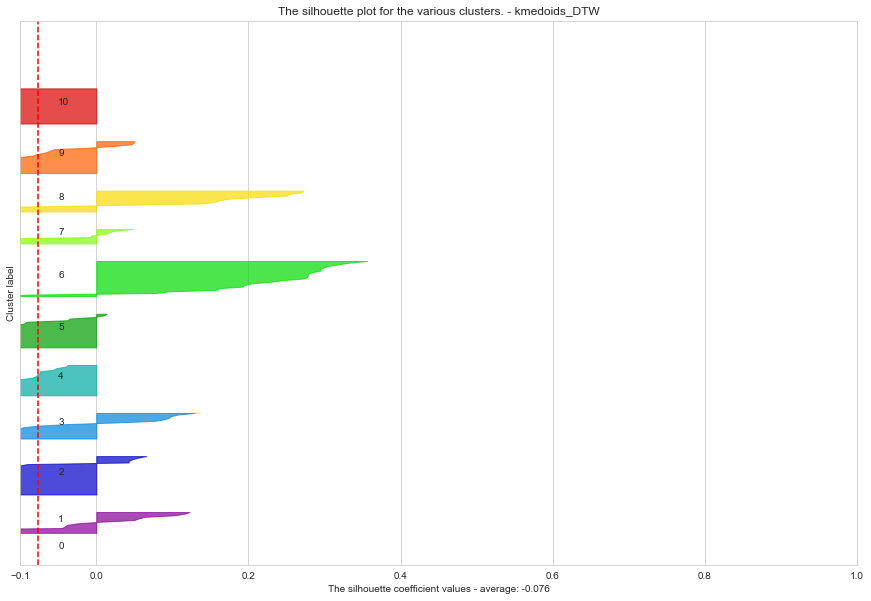

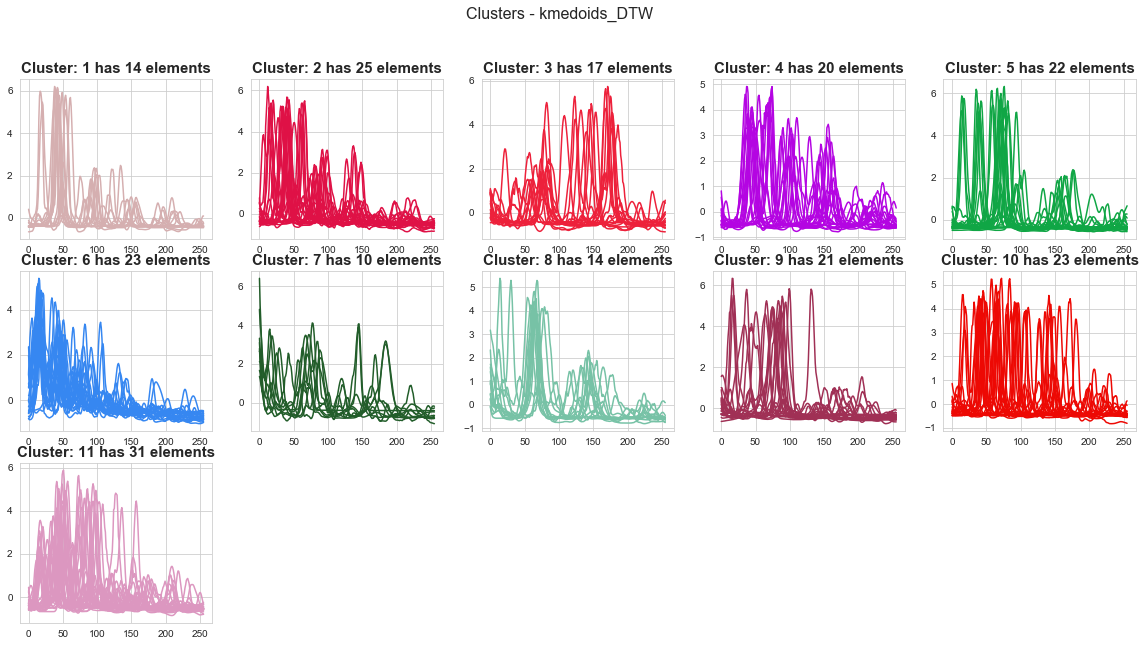

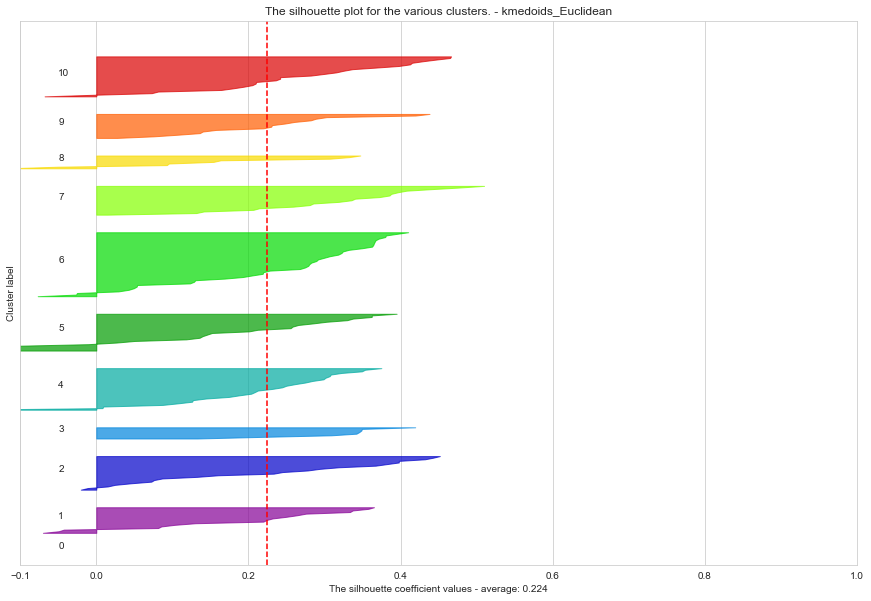

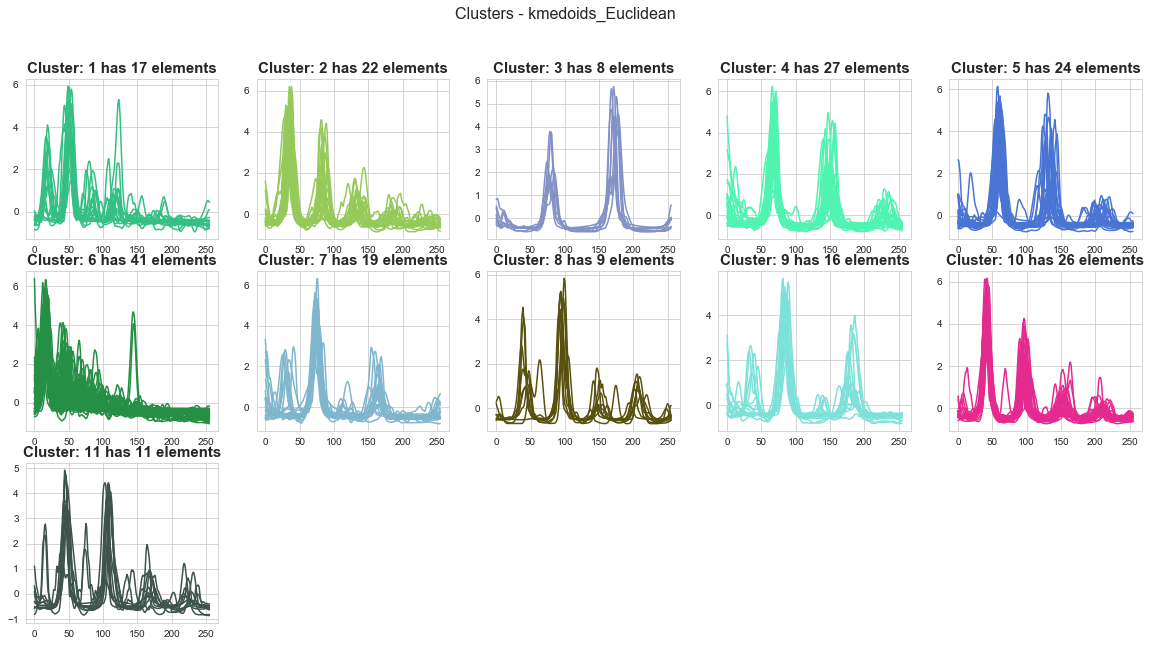

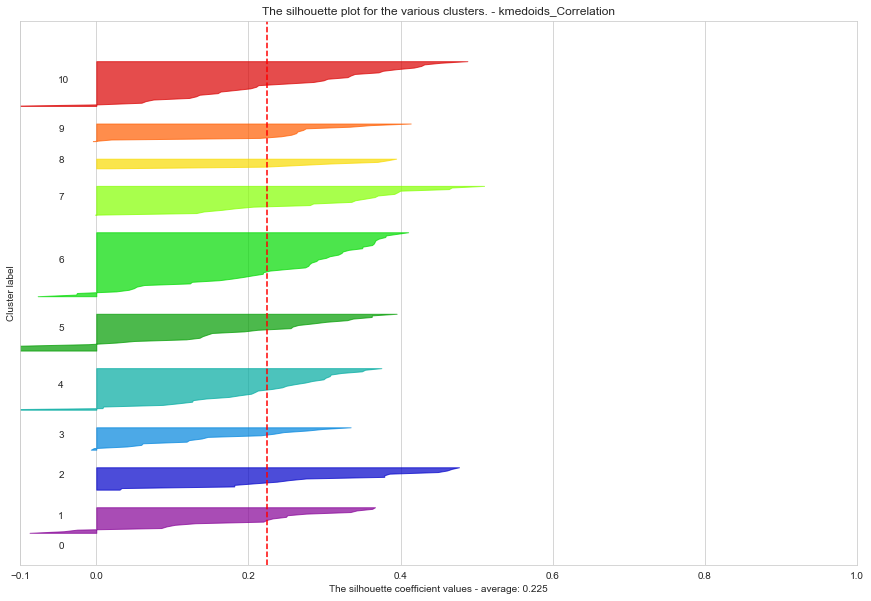

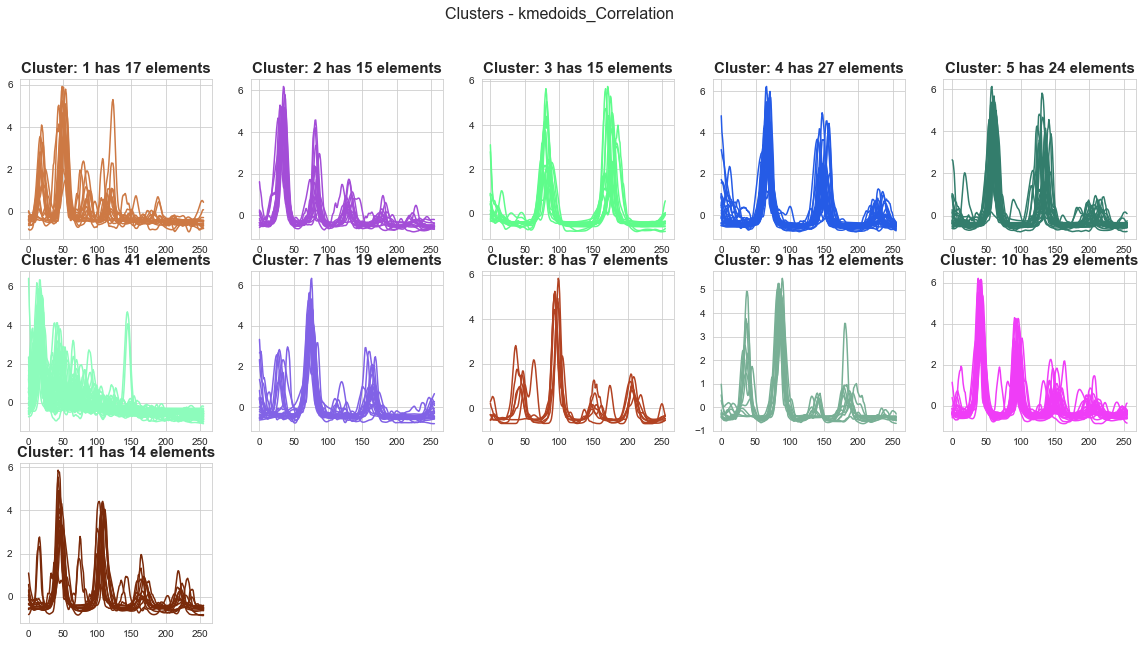

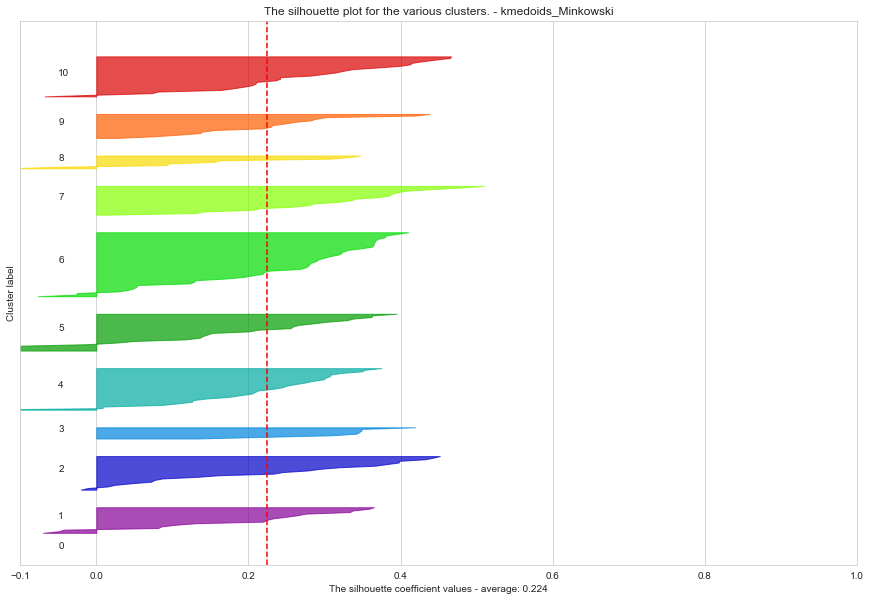

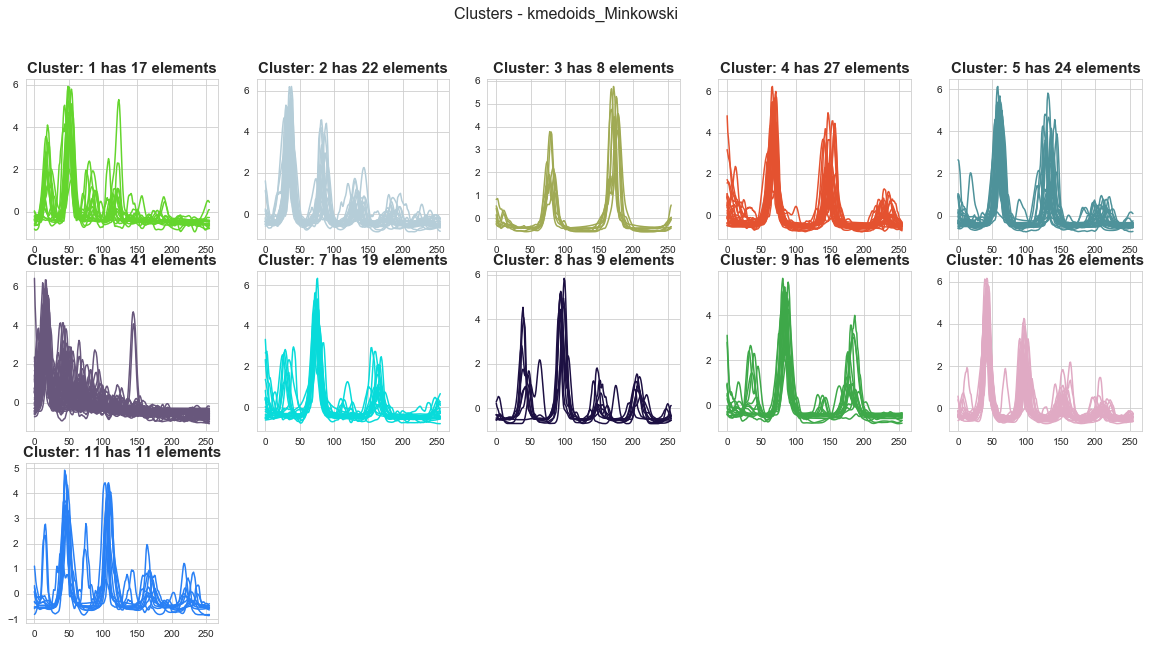

In [19]:
idx = data.shape[1]
label_cols = test_data.iloc[:,idx+1:].columns

for i, label in enumerate(label_cols):
    ts_silhouette_plot(data, test_data[label])
    plot_ts_clusters(data, test_data[label])